# 📑 &nbsp; Deep Learning. Breed Recognition
<a href='https://olgabelitskaya.gitlab.io/index.html'>
&#x1F300; &nbsp; Homepage &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.gitlab.io/deep_learning_projects/index.html'>
&#x1F300; &nbsp; Project List &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.github.io/README.html'>
&#x1F300; &nbsp; GitHub Pages &nbsp; &nbsp;</a>
<a href='https://olgabelitskaya.gitlab.io/deep_learning_projects/DL_PP5_0_SMC.html'>&#x1F300; &nbsp; Main &nbsp; &nbsp;</a><br/>
<a href='https://www.instagram.com/olga.belitskaya/'>
&#x1F300; &nbsp; Instagram Posts &nbsp; &nbsp;</a>
<a href='https://www.pinterest.ru/olga_belitskaya/code-style/'>
&#x1F300; &nbsp; Pinterest Posts</a><br/>
For this project, I have created the dataset of about color images with horse breeds.<br/>

## ✒️ &nbsp; Modules, Settings, & Helpful Functions

In [ ]:
!python3 -m pip install neural_structured_learning \
--user --quiet --no-warn-script-location

In [ ]:
sys_path='/root/.local/lib/python3.6/site-packages'
import sys; sys.path.append(sys_path)
import warnings; warnings.filterwarnings('ignore')
import h5py,urllib,torch,os,imageio
import tensorflow as tf,tensorflow_hub as th
import pandas as pd,numpy as np,pylab as pl,sympy as sp
import tensorflow.keras.layers as tkl
import tensorflow.keras.callbacks as tkc
import neural_structured_learning as nsl
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torchvision import transforms,utils,models
import torch.nn.functional as tnnf,torch.nn as tnn
dev=torch.device('cuda:0' \
if torch.cuda.is_available() else 'cpu')
from IPython.core.display import display,HTML,Image
from IPython.core.magic import register_line_magic

In [ ]:
file_path='https://raw.githubusercontent.com/OlgaBelitskaya/data_kitchen/main/'
file_name='HorseBreeds160.h5'
img_path='https://olgabelitskaya.gitlab.io/data/horses/'
img_files=['00_05_001.png','00_06_001.png']
img_size=64; data_img_size=160
batch_size2=8; img_size2=64
max_img_size=224; steps=60

 ## ✒️ &nbsp; Data Loading and Preprocessing

In [ ]:
def get_file(file_path,file_name):
    input_file=urllib.request.urlopen(file_path+file_name)
    output_file=open(file_name,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
get_file(file_path,file_name)
with h5py.File(file_name,'r') as f:
    keys=list(f.keys())
    sp.pretty_print('file keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    images=tf.image.resize(
        images,[data_img_size,data_img_size]).numpy()
    labels=np.array(f[keys[1]],dtype='float32')
    names=[el.decode('utf-8') for el in f[keys[2]]]
    f.close()

file keys: images, labels, names


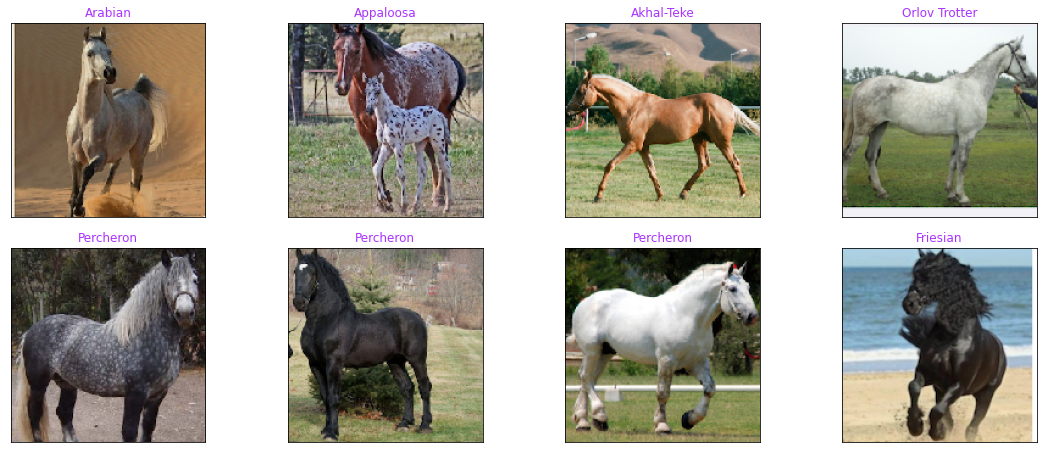

train              valid               test
image shape  (536, 160, 160, 3)  (67, 160, 160, 3)  (67, 160, 160, 3)
image type              float32            float32            float32
label shape              (536,)              (67,)              (67,)
label type              float32            float32            float32

In [ ]:
N=labels.shape[0]; n=int(.1*N); num_classes=len(names)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
def display_imgs(images,labels,names,fig_size=16,start0=False):
    fig=pl.figure(figsize=(fig_size,fig_size/2.5))
    randi=np.random.randint(0,200)
    if start0==True: randi=0
    for i in range(randi,randi+8):
        ax=fig.add_subplot(2,4,i-randi+1,xticks=[],yticks=[])
        ax.set_title(names[int(labels[i])],color='#aa33ff',
                     fontdict={'fontsize':'large'})
        ax.imshow((images[i]))
    pl.tight_layout(); pl.show()
display_imgs(images,labels,names); display(df)

In [ ]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]
n_train=batch_size2*(x_train.shape[0]//batch_size2)
x_train2=tf.image.resize(x_train,[img_size2,img_size2])
x_train2=np.transpose(x_train2.numpy(),(0,3,1,2))[:n_train]
print(x_train2.mean(),x_train2.std())
n_valid=batch_size2*(x_valid.shape[0]//batch_size2)
x_valid2=tf.image.resize(x_valid,[img_size2,img_size2])
x_valid2=np.transpose(x_valid2.numpy(),(0,3,1,2))[:n_valid]
n_test=batch_size2*(x_test.shape[0]//batch_size2)
x_test2=tf.image.resize(x_test,[img_size2,img_size2])
x_test2=np.transpose(x_test2.numpy(),(0,3,1,2))[:n_test]
random_seed=23
train2=TData(x_train2,y_train[:n_train])
valid2=TData(x_valid2,y_valid[:n_valid])
test2=TData(x_test2,y_test[:n_test])
dataloaders={'train':tdl(dataset=train2,shuffle=True,batch_size=batch_size2), 
             'valid':tdl(dataset=valid2,shuffle=True,batch_size=batch_size2),
             'test':tdl(dataset=test2,shuffle=True,batch_size=batch_size2)}

0.49232626 0.2689173


Image dimensions: torch.Size([8, 3, 64, 64])
Label dimensions: torch.Size([8])


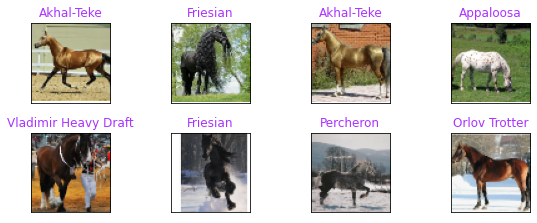

In [ ]:
@register_line_magic
def display_data_imgs(data):
    global names
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        images=[np.transpose(images[i],(1,2,0)) 
                for i in range(len(images))]
        display_imgs(images,labels,names,fig_size=8,start0=True)
        break
%display_data_imgs valid

## ✒️ &nbsp; Classification Models
### TFHub

In [ ]:
def keras_history_plot(fit_history,fig_size=12,color='#aa33ff'):
    keys=list(fit_history.history.keys())
    list_history=[fit_history.history[keys[i]] 
                  for i in range(len(keys))]
    dfkeys=pd.DataFrame(list_history).T
    dfkeys.columns=keys
    fig=pl.figure(figsize=(fig_size,fig_size//2))
    ax1=fig.add_subplot(2,1,1)
    dfkeys.iloc[:,[int(0),int(2)]].plot(
        ax=ax1,color=['slategray',color],grid=True)
    ax2=fig.add_subplot(2,1,2)
    dfkeys.iloc[:,[int(1),int(3)]].plot(
        ax=ax2,color=['slategray',color],grid=True)
    pl.tight_layout(); pl.show()

In [ ]:
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tkl.Input((pix,pix,3),name='input'),
        th.KerasLayer(mh,trainable=True),
        tkl.Flatten(),
        tkl.Dense(den,activation='relu'),
        tkl.Dropout(rate=.5),
        tkl.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model

In [ ]:
handle_base='mobilenet_v2_100_160'
mhandle='https://tfhub.dev/google/imagenet/{}/classification/4'\
.format(handle_base)

In [ ]:
fw='/tmp/checkpoint'
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=int(0),save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
kmodel=premodel(data_img_size,2048,mhandle,num_classes,
                'softmax','sparse_categorical_crossentropy')
history=kmodel.fit(x=x_train,y=y_train,batch_size=16,epochs=50,
                   callbacks=[checkpointer,early_stopping,lr_reduction],
                   validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              3540265   
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              2052096   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 14343     
Total params: 5,606,704
Trainable params: 5,572,592
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/50
34/34 [==============================] - 10s 92ms/step - loss: 2.3948 - accuracy: 0.4568 - val_loss: 5.2421 - val_accuracy: 0.3881
Epoch 2/50
34/34 [==============================] - 2s 58ms/step - loss: 1.1548 - accuracy: 0.6824 - val_loss: 23.1388 - val_accuracy: 0.3433
Epoch 3/50
34/34 [==============================] - 2s 59ms/step - loss: 1.0033 - accuracy: 0.7454 - val_loss: 3.3178 - val_accuracy: 0.6567
Epoch 4/50
34/34 [==============================] - 2s 58ms/step - loss: 0.7929 - accuracy: 0.8032 - val_loss: 5.6553 - val_accuracy: 0.4925
Epoch 5/50
34/34 [==============================] - 2s 58ms/step - loss: 1.0975 - accuracy: 0.7289 - val_loss: 6.1705 - val_accuracy: 0.4179
Epoch 6/50
34/34 [==============================] - 2s 58ms/step - loss: 1.0437 - accuracy: 0.7902 - val_loss: 8.5537 - val_accuracy: 0.2836
Epoch 7/50
34/34 [==============================] - 2s 59ms/step - loss: 0.9073 - accuracy: 0.7987 - val_loss: 4.2233 - val_accuracy: 0.5224
Epoch 8/50


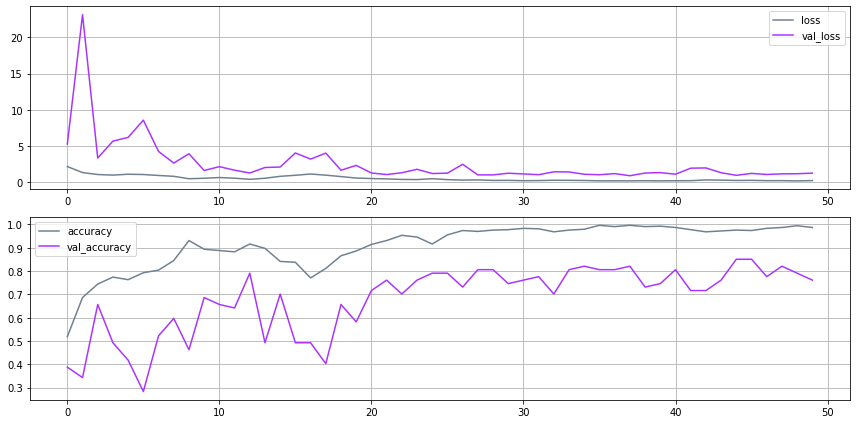

In [ ]:
keras_history_plot(history)

In [ ]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=0))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)
y_test_predict,y_test

[1.0588504076004028, 0.9104477763175964]


(array([0, 5, 2, 0, 1, 2, 1, 0, 2, 5, 4, 0, 5, 6, 0, 2, 6, 6, 6, 1, 0, 6,
        6, 4, 5, 1, 0, 0, 0, 1, 2, 2, 2, 6, 6, 5, 3, 6, 5, 6, 2, 1, 0, 2,
        4, 5, 4, 0, 4, 0, 2, 4, 5, 0, 3, 6, 2, 1, 0, 5, 4, 5, 1, 5, 3, 6,
        5]),
 array([0., 5., 2., 0., 1., 2., 1., 0., 2., 5., 4., 0., 4., 6., 0., 2., 6.,
        6., 6., 1., 0., 6., 6., 4., 5., 1., 3., 0., 0., 1., 4., 2., 2., 6.,
        6., 5., 3., 6., 5., 6., 1., 1., 0., 2., 4., 5., 4., 0., 4., 0., 2.,
        4., 5., 0., 5., 6., 5., 1., 0., 5., 4., 5., 1., 5., 3., 6., 5.],
       dtype=float32))

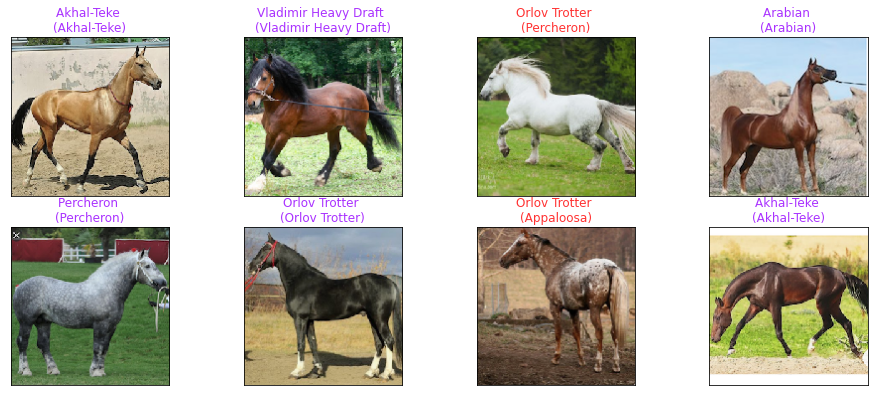

In [ ]:
fig=pl.figure(figsize=(16,16/2.5))
randch=np.random.choice(
    x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=int(y_test[idx])
    ax.set_title('{} \n({})'.format(
        names[pred_idx],names[true_idx]),
        color=('#aa33ff' if pred_idx==true_idx else '#ff3333'))
pl.show()

### CNN Like

In [ ]:
def kmodel(leaky_alpha,num_classes=num_classes):
    model=tf.keras.Sequential()
    model.add(tkl.Conv2D(
        32,(5,5),padding='same', 
        input_shape=[data_img_size,data_img_size,3]))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))   
    model.add(tkl.GlobalMaxPooling2D())     
    model.add(tkl.Dense(1024))
    model.add(tkl.LeakyReLU(alpha=leaky_alpha))
    model.add(tkl.Dropout(.5))     
    model.add(tkl.Dense(num_classes))
    model.add(tkl.Activation('softmax'))   
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])   
    return model
kmodel=kmodel(.01)

In [ ]:
early_stopping=tkc.EarlyStopping(
    monitor='val_loss',patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(
    filepath=fw,verbose=0,save_weights_only=True,
    monitor='val_accuracy',mode='max',save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(
    monitor='val_loss',verbose=2,patience=5,factor=.8)
history=kmodel.fit(x_train,y_train,epochs=70,batch_size=16,verbose=2,
                   validation_data=(x_valid,y_valid),
                   callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/70
34/34 - 2s - loss: 1.9278 - accuracy: 0.1660 - val_loss: 1.9015 - val_accuracy: 0.1642
Epoch 2/70
34/34 - 1s - loss: 1.8853 - accuracy: 0.1791 - val_loss: 1.8406 - val_accuracy: 0.2537
Epoch 3/70
34/34 - 1s - loss: 1.8389 - accuracy: 0.2276 - val_loss: 1.7686 - val_accuracy: 0.4627
Epoch 4/70
34/34 - 1s - loss: 1.7286 - accuracy: 0.3153 - val_loss: 1.7436 - val_accuracy: 0.3433
Epoch 5/70
34/34 - 1s - loss: 1.6357 - accuracy: 0.3489 - val_loss: 1.6084 - val_accuracy: 0.4925
Epoch 6/70
34/34 - 1s - loss: 1.6454 - accuracy: 0.3694 - val_loss: 1.6205 - val_accuracy: 0.4478
Epoch 7/70
34/34 - 1s - loss: 1.5586 - accuracy: 0.3974 - val_loss: 1.5415 - val_accuracy: 0.5075
Epoch 8/70
34/34 - 1s - loss: 1.4361 - accuracy: 0.4534 - val_loss: 1.5795 - val_accuracy: 0.3881
Epoch 9/70
34/34 - 1s - loss: 1.3274 - accuracy: 0.5187 - val_loss: 1.5168 - val_accuracy: 0.4328
Epoch 10/70
34/34 - 1s - loss: 1.1960 - accuracy: 0.5653 - val_loss: 1.5104 - val_accuracy: 0.4776
Epoch 11/70
34/34 -

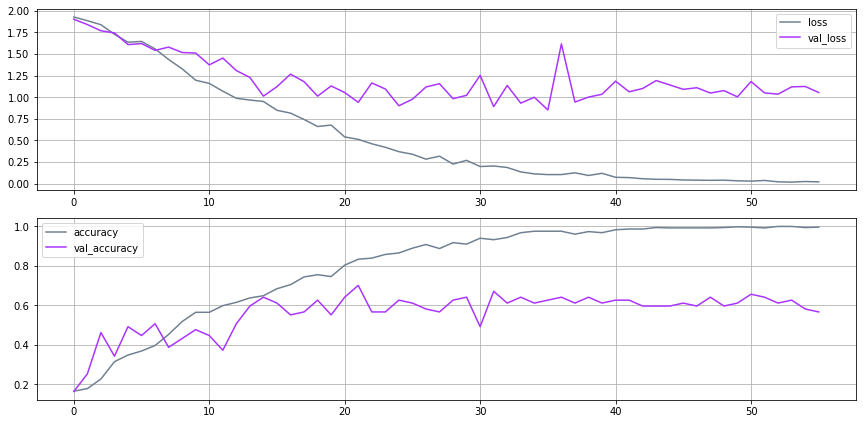

In [ ]:
keras_history_plot(history)

In [ ]:
kmodel.load_weights(fw)
sp.pretty_print(kmodel.evaluate(x_test,y_test,verbose=int(0)))
y_test_predict=np.argmax(kmodel.predict(x_test),axis=-1)

[1.0936137437820435, 0.5223880410194397]


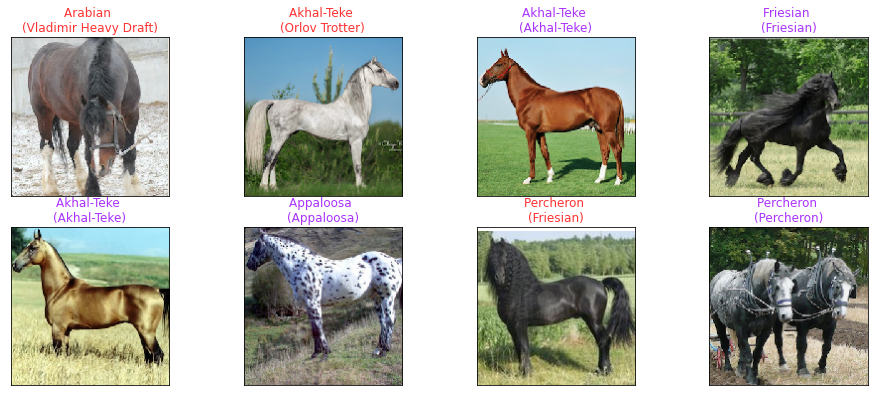

In [ ]:
fig=pl.figure(figsize=(16,16/2.5))
randch=np.random.choice(
    x_test.shape[0],size=8,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,4,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx=y_test_predict[idx]
    true_idx=int(y_test[idx])
    ax.set_title('{} \n({})'.format(
        names[pred_idx],names[true_idx]),
        color=('#aa33ff' if pred_idx==true_idx else '#ff3333'))
pl.show()

### CNN Based Models with Adversarial Regularization

In [ ]:
base_model=tf.keras.Sequential([
    tkl.Input((data_img_size,data_img_size,3),name='input'),
    tkl.Conv2D(32,(5,5),padding='same'),
    tkl.LeakyReLU(alpha=.1),
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.Conv2D(196,(5,5)),
    tkl.LeakyReLU(alpha=.1),    
    tkl.MaxPooling2D(pool_size=(2,2)),
    tkl.Dropout(.25),
    tkl.GlobalMaxPooling2D(),    
    tkl.Dense(512),
    tkl.LeakyReLU(alpha=.1),
    tkl.Dropout(.25),
    tkl.Dense(128),
    tkl.LeakyReLU(alpha=.1),
    tkl.Dropout(.25),
    tkl.Dense(num_classes,activation='softmax')])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
model_weights='/tmp/checkpoint'
checkpointer=tkc.ModelCheckpoint(
    filepath=model_weights,verbose=2,save_weights_only=True,
    monitor='val_sparse_categorical_accuracy',
    mode='max',save_best_only=True)
adv_model.compile(optimizer='nadam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')

In [ ]:
batch_size=16; epochs=50
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train}).batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid}).batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,
              verbose=2,callbacks=[checkpointer],
              validation_steps=valid_steps,epochs=epochs);

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


34/34 - 17s - loss: 2.3078 - sparse_categorical_crossentropy: 1.9230 - sparse_categorical_accuracy: 0.1642 - scaled_adversarial_loss: 0.3848 - val_loss: 2.2701 - val_sparse_categorical_crossentropy: 1.8914 - val_sparse_categorical_accuracy: 0.2500 - val_scaled_adversarial_loss: 0.3788
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.25000, saving model to /tmp/checkpoint
Epoch 2/50
34/34 - 1s - loss: 2.2559 - sparse_categorical_crossentropy: 1.8808 - sparse_categorical_accuracy: 0.2034 - scaled_adversarial_loss: 0.3751 - val_loss: 2.2218 - val_sparse_categorical_crossentropy: 1.8508 - val_sparse_categorical_accuracy: 0.3438 - val_scaled_adversarial_loss: 0.3711

Epoch 00002: val_sparse_categorical_accuracy improved from 0.25000 to 0.34375, saving model to /tmp/checkpoint
Epoch 3/50
34/34 - 1s - loss: 2.2100 - sparse_categorical

In [ ]:
adv_model.load_weights(model_weights)
adv_model.evaluate({'input':x_test,'label':y_test})

3/3 [==============================] - 0s 33ms/step - loss: 2.0138 - sparse_categorical_crossentropy: 1.6145 - sparse_categorical_accuracy: 0.5373 - scaled_adversarial_loss: 0.3992


[2.0137524604797363, 1.6145108938217163, 0.5373134613037109, 0.39924156665802]

### PyTorch Models

In [ ]:
tmodel=models.vgg16(pretrained=True)
for param in tmodel.parameters(): param.requires_grad=False
tmodel.classifier[3].requires_grad=True
tmodel

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev).long()
        logits=model(features)
        _,pred_labels=torch.max(logits,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100
def epoch_loss(model,data_loader):
    model.eval()
    curr_loss,num_examples=0.,0
    with torch.no_grad():
        for features,targets in data_loader:
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=model(features)
            loss=tnnf.cross_entropy(logits,targets,
                                    reduction='sum')
            num_examples+=targets.size(0)
            curr_loss+=loss
        return curr_loss/num_examples

In [ ]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        tmodel.train()
        for batch_ids,(features,targets) \
        in enumerate(dataloaders['train']):        
            features=features.to(dev)
            targets=targets.to(dev).long()
            logits=tmodel(features)
            cost=tnnf.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            str1='epoch: %03d/%03d | batch: %03d/%03d | cost: %.4f'
            if not batch_ids%10:
                sp.pretty_print(str1%(epoch+1,epochs,batch_ids,
                                      len(dataloaders['train']),cost))
        tmodel.eval()
        with torch.set_grad_enabled(False):
            sp.pretty_print('epoch: %03d/%03d'%(epoch+1,epochs))
            str2='train acc/loss: %.2f%%/%.2f valid acc/loss: %.2f%%/%.2f'
            sp.pretty_print(str2%\
                  (model_acc(tmodel,dataloaders['train']),
                   epoch_loss(tmodel,dataloaders['train']),
                   model_acc(tmodel,dataloaders['valid']),
                   epoch_loss(tmodel,dataloaders['valid'])))

In [ ]:
tmodel.classifier[6]=tnn.Sequential(
    tnn.Linear(4096,512),tnn.ReLU(),
    tnn.Dropout(.5),tnn.Linear(512,num_classes))
tmodel=tmodel.to(dev)
optimizer=torch.optim.Adam(tmodel.parameters())

In [ ]:
%train_run 15

epoch: 001/015 | batch: 000/067 | cost: 2.0886
epoch: 001/015 | batch: 010/067 | cost: 1.7570
epoch: 001/015 | batch: 020/067 | cost: 1.5516
epoch: 001/015 | batch: 030/067 | cost: 2.0911
epoch: 001/015 | batch: 040/067 | cost: 2.5640
epoch: 001/015 | batch: 050/067 | cost: 1.1761
epoch: 001/015 | batch: 060/067 | cost: 2.0228
epoch: 001/015
train acc/loss: 62.50%/1.03 valid acc/loss: 51.56%/1.26
epoch: 002/015 | batch: 000/067 | cost: 0.8261
epoch: 002/015 | batch: 010/067 | cost: 1.2836
epoch: 002/015 | batch: 020/067 | cost: 1.7091
epoch: 002/015 | batch: 030/067 | cost: 1.0138
epoch: 002/015 | batch: 040/067 | cost: 1.3263
epoch: 002/015 | batch: 050/067 | cost: 1.5513
epoch: 002/015 | batch: 060/067 | cost: 1.5962
epoch: 002/015
train acc/loss: 65.30%/0.95 valid acc/loss: 65.62%/1.18
epoch: 003/015 | batch: 000/067 | cost: 1.6416
epoch: 003/015 | batch: 010/067 | cost: 0.8287
epoch: 003/015 | batch: 020/067 | cost: 1.6367
epoch: 003/015 | batch: 030/067 | cost: 1.1792
epoch: 003/0

In [ ]:
tmodel.eval()
with torch.set_grad_enabled(False):
    print('train acc: %.2f%% | test acc: %.2f%%'%\
          (model_acc(tmodel,dataloaders['train']),
           model_acc(tmodel,dataloaders['test'])))

train acc: 94.22% | test acc: 56.25%


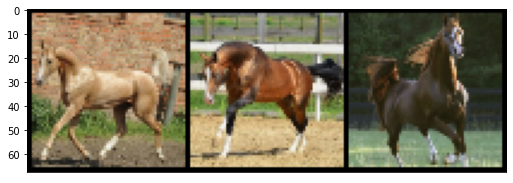


true labels:            Akhal-Teke          Akhal-Teke             Arabian

predictions:            Akhal-Teke             ArabianVladimir Heavy Draft


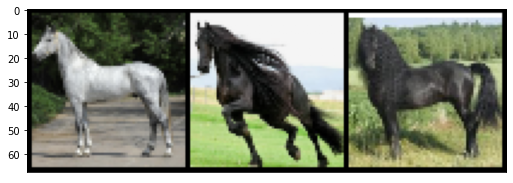


true labels:         Orlov Trotter            Friesian            Friesian

predictions:         Orlov Trotter       Orlov Trotter            Friesian


In [ ]:
def show_image(img):
    npimg=img.numpy(); tr=(1,2,0)
    pl.figure(figsize=(12,3))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
with torch.no_grad():
    for i,(timages,tlabels) in enumerate(dataloaders['test']):
        show_image(utils.make_grid(timages[:3]))
        print('\ntrue labels: ',
              ''.join('%20s'%names[tlabels[j]] for j in range(3)))
        timages=timages.to(dev)
        tlabels=tlabels.to(dev)
        outputs=tmodel(timages)
        _,tpreds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%20s'%names[tpreds[j]] for j in range(3)))
        if i==1: break

## ✒️ &nbsp; Super Resolution

In [ ]:
def esrgantf2_superresolution(img,img_size=50):
    model=th.load('https://tfhub.dev/captain-pool/esrgan-tf2/1')
    func=model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    func.inputs[0].set_shape([1,img_size,img_size,3])
    converter=tf.lite.TFLiteConverter.from_concrete_functions([func])
    converter.optimizations=[tf.lite.Optimize.DEFAULT]
    tflite_model=converter.convert()
    with tf.io.gfile.GFile('ESRGAN.tflite','wb') as f:
        f.write(tflite_model)
    esrgan_model_path='./ESRGAN.tflite'
    if img.mean()<1.: img=img*255.
    lr=tf.image.resize(img,[img_size,img_size])
    lr=tf.expand_dims(lr.numpy()[:,:,:int(3)],axis=int(0))
    lr=tf.cast(lr,tf.float32)
    interpreter=tf.lite.Interpreter(model_path=esrgan_model_path)
    interpreter.allocate_tensors()
    input_details=interpreter.get_input_details()
    output_details=interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'],lr)
    interpreter.invoke()
    output_data=interpreter.get_tensor(output_details[0]['index'])
    sr=tf.squeeze(output_data,axis=0)
    sr=tf.clip_by_value(sr,0,255)
    sr=tf.round(sr); sr=tf.cast(sr,tf.uint8)
    lr=tf.cast(tf.squeeze(lr,axis=0),tf.uint8)
    return lr,sr
img=images[0]
lr,sr=esrgantf2_superresolution(img,img_size)

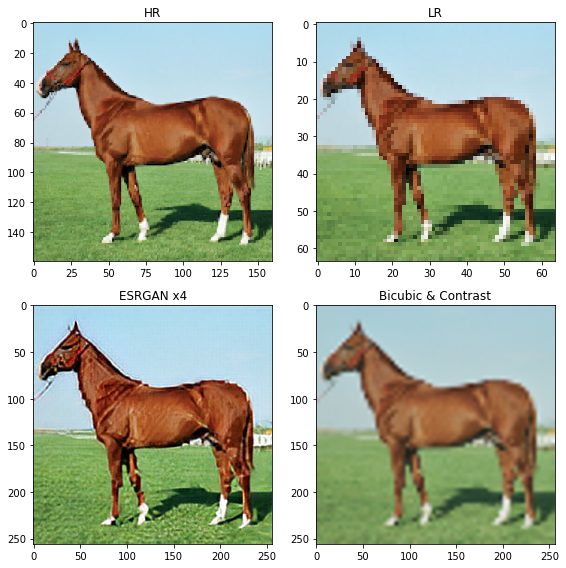

In [ ]:
def low2superbicubic_imgs(img,lr,sr,img_size=img_size):
    pl.figure(figsize=(8,8))
    pl.subplot(2,2,1); pl.title('HR'); pl.imshow(img)
    pl.subplot(2,2,2); pl.title('LR'); pl.imshow(lr.numpy())
    pl.subplot(2,2,3); pl.title('ESRGAN x4'); pl.imshow(sr.numpy())
    bicubic=tf.image.resize(
        lr,[img_size*int(4),img_size*int(4)],tf.image.ResizeMethod.BICUBIC)
    bicubic_contrast=tf.image.adjust_contrast(bicubic,float(.8))
    bicubic_contrast=tf.cast(bicubic_contrast,tf.uint8)
    pl.subplot(2,2,4); pl.title('Bicubic & Contrast')
    pl.imshow(bicubic_contrast.numpy())
    pl.tight_layout(); pl.show()
low2superbicubic_imgs(img,lr,sr)

## ✒️  Color Interpolation

In [ ]:
def hyper_interpolate(v1,v2,steps,max_img_size=max_img_size):
    for img in [v1,v2]:
        img=tf.image.resize(img,[max_img_size,max_img_size])
    v1norm=tf.norm(v1); v2norm=tf.norm(v2)
    vectors=[]; v2normalized=v2*(v1norm/v2norm)
    for step in range(steps):
        interpolated=v1+(v2normalized-v1)*step/(steps-int(1))
        interpolated_norm=tf.norm(interpolated)
        interpolated_normalized=interpolated*(v1norm/interpolated_norm)
        vectors.append(interpolated_normalized)
    return tf.stack(vectors).numpy()
imgs=tf.concat([hyper_interpolate(x_valid[0],x_test[0],steps),
                hyper_interpolate(x_test[0],x_valid[0],steps)],axis=0)  

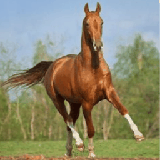

In [ ]:
file_name='pic.gif'
imgs=np.array(imgs*float(255),dtype=np.uint8)
imageio.mimsave(file_name,imgs)
Image(open('pic.gif','rb').read())

## ✒️  Object Recognition

In [ ]:
from tensorflow.keras.applications import vgg19,VGG19
mvgg19=VGG19(include_top=True,weights='imagenet')

In [ ]:
def load_img(img_file,max_img_size=max_img_size):
    img=tf.io.read_file(img_file)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    scale=max_img_size/max(shape)
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]
def tensor2img(tensor):
    if np.ndim(tensor)>int(3):
        assert tensor.shape[0]==1; tensor=tensor[0]
    pl.figure(figsize=(3,3)); pl.imshow(tensor)
    pl.tight_layout(); pl.show()
for f in img_files:
    input_file=urllib.request.urlopen(img_path+f)
    output_file=open(f,'wb')
    output_file.write(input_file.read())
    output_file.close(); input_file.close()

example #1


class name      prob
0               sorrel  0.994069
1         Ibizan_hound  0.002617
2  Rhodesian_ridgeback  0.001144
3               Saluki  0.000506
4              basenji  0.000221

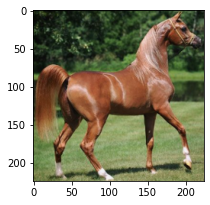

example #2


class name      prob
0       curly-coated_retriever  0.292417
1           Scottish_deerhound  0.178905
2        flat-coated_retriever  0.047128
3  German_short-haired_pointer  0.043551
4              standard_poodle  0.042754

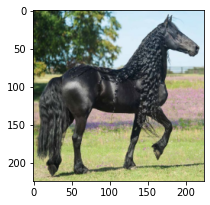

In [ ]:
for i in range(len(img_files)):
    content_img=load_img(img_files[i])
    x=vgg19.preprocess_input(content_img*255)
    prediction_probabilities=mvgg19(x)
    predict_top5=vgg19.decode_predictions(
        prediction_probabilities.numpy())[0]
    sp.pretty_print('example #%d'%(i+1))
    display(pd.DataFrame(
        [[class_name,prob] 
         for (number,class_name,prob) in predict_top5],
        columns=['class name','prob']))
    tensor2img(content_img)